In [1]:
import csv
from collections import defaultdict
from collections import namedtuple
from functools import partial
from itertools import product
from pathlib import Path
from typing import TypedDict

import torch
import seaborn as sns
from torch import nn
from torch.utils.data.dataloader import DataLoader
from torchvision import models as tv_models
from torchvision.datasets import CIFAR10
from tqdm import tqdm

In [2]:
BATCH_SIZE = 100
LR = 0.001
OUT_FILEPATH = Path("./results.csv")
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

# Output file settings
ERASE_RESULTS = True
FIELDS = ["model_desc", "accuracy",]


class Row(TypedDict):
    model_desc: str
    accuracy: float


torch.manual_seed(42);

In [3]:
def one_hot(class_: int) -> torch.Tensor:
    vec = torch.zeros(10, dtype=torch.float32)
    vec[class_] = 1.0

    return vec

In [4]:
dataset_factory = partial(CIFAR10, root="./data", download=True, target_transform=one_hot)
train_dataset_factory = partial(dataset_factory, train=True)
test_dataset_factory = partial(dataset_factory, train=False)
dataloader_factory = partial(DataLoader, batch_size=BATCH_SIZE)

In [5]:
# Create/erase output file for results
if ERASE_RESULTS:
    with open(OUT_FILEPATH, 'w', newline='') as out:
        csv_writer = csv.DictWriter(out, FIELDS)

        # Write data from previous practice
        csv_writer.writerow(Row(
            model_desc='ResNet18\n Special for CIFAR10',
            accuracy=0.91,
        ))

    del out

In [6]:
def classifier(in_features, deep=False, num_classes=10):
    if not deep:
        return nn.Linear(in_features, num_classes)

    hidden_size = in_features // 2

    return nn.Sequential(
        nn.Linear(in_features, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, num_classes),
    )

In [7]:
def get_correct(predictions, ground_truth) -> int:
    with torch.no_grad():
        correct = (
            (predictions.argmax(dim=1) == ground_truth.argmax(dim=1))
            .cpu()
            .detach()
            .to(torch.int32)
            .sum()
            .item()
        )

    return correct

In [8]:
def train_model(model, dataloader, criterion, optimizer, num_epochs) -> float:
    model = model.to(DEVICE)
    model.train()
    accuracy = 0

    for epoch_no in range(1, num_epochs + 1):
        running_loss = 0
        train_mean_loss = 0
        correct = 0
        total = 0

        for signals, ground_truth in tqdm(
            dataloader,
            desc='Train batches',
            total=len(dataloader),
        ):
            optimizer.zero_grad()

            signals = signals.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)

            predictions = model(signals)
            loss_value = criterion(predictions, ground_truth)
            loss_value.backward()

            optimizer.step()

            correct += get_correct(predictions, ground_truth)
            total += len(predictions)
            mean_loss = torch.mean(loss_value.cpu().detach()).item()
            running_loss += mean_loss

            train_mean_loss = running_loss / len(dataloader)

        accuracy = correct / total

        print(
            f'Epoch: {epoch_no:02d} '
            f'| train loss: {train_mean_loss:.4f} '
            f'| accuracy: {accuracy:.4f}\n'
        )

    return accuracy


def test_model(model, dataloader) -> float:
    model = model.to(DEVICE)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data, ground_truth in tqdm(
            dataloader,
            desc='Test batches',
            total=len(dataloader),
        ):
            data = data.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)

            predictions = model(data)
            correct += get_correct(predictions, ground_truth)
            total += len(predictions)

    return correct / total

In [9]:
Pretrained = namedtuple('Model', ['model', 'weights', 'out_features', 'name'])

# Each model has either 'fc' nor 'classifier' linear layer attribute
pretrained = [
    Pretrained(tv_models.resnet18, tv_models.ResNet18_Weights.DEFAULT, 'ResNet18', 512),
    Pretrained(tv_models.mobilenet_v3_small, tv_models.MobileNet_V3_Small_Weights.DEFAULT, 'MobileNetV3 S', 576),
    Pretrained(tv_models.efficientnet_v2_s, tv_models.EfficientNet_V2_S_Weights.DEFAULT, 'EfficientNetV2 S', 1280),
    Pretrained(tv_models.mnasnet0_5, tv_models.MNASNet0_5_Weights.DEFAULT, 'MNASNet 0.5', 1280),
]

In [10]:
Config = namedtuple('Config', ['deep', 'num_epochs'])

configs = [
    Config(deep=False, num_epochs=4),
    Config(deep=True, num_epochs=7),
]

In [11]:
for (pretrained_model, weights, model_name, out_features), config in product(pretrained, configs):
    transform = weights.transforms()

    train_dataloader = dataloader_factory(train_dataset_factory(transform=transform))
    test_dataloader = dataloader_factory(test_dataset_factory(transform=transform))

    model = pretrained_model(weights=weights)

    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # Add new classifier
    classifier_placeholder = classifier(out_features, deep=config.deep)

    if hasattr(model, 'fc'):
        model.fc = classifier_placeholder
    elif hasattr(model, 'classifier'):
        model.classifier = classifier_placeholder
    else:
        raise RuntimeError("Model does not have known out layers")

    criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(
        (getattr(model, 'fc', None) or getattr(model, 'classifier')).parameters(),
        LR,
    )

    print(model)

    __ = train_model(model, train_dataloader, criterion, optimizer, config.num_epochs)
    test_accuracy = test_model(model, test_dataloader)

    with open(OUT_FILEPATH, 'a', newline='') as out:
        csv_writer = csv.DictWriter(out, FIELDS)
        addon = '\nDeep classifier' if config.deep else ''

        csv_writer.writerow(Row(
            model_desc=model_name + addon + f'\n{config.num_epochs} epochs',
            accuracy=test_accuracy,
        ))


Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

Train batches: 100%|██████████| 500/500 [01:14<00:00,  6.67it/s]


Epoch: 01 | train loss: 0.9529 | accuracy: 0.6922



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch: 02 | train loss: 0.6971 | accuracy: 0.7617



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.91it/s]


Epoch: 03 | train loss: 0.6597 | accuracy: 0.7736



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.88it/s]


Epoch: 04 | train loss: 0.6410 | accuracy: 0.7780



Test batches: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.87it/s]


Epoch: 01 | train loss: 0.8385 | accuracy: 0.7145



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.91it/s]


Epoch: 02 | train loss: 0.6708 | accuracy: 0.7661



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Epoch: 03 | train loss: 0.6370 | accuracy: 0.7781



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.87it/s]


Epoch: 04 | train loss: 0.6105 | accuracy: 0.7864



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Epoch: 05 | train loss: 0.5829 | accuracy: 0.7964



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.92it/s]


Epoch: 06 | train loss: 0.5567 | accuracy: 0.8055



Train batches: 100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch: 07 | train loss: 0.5308 | accuracy: 0.8148



Test batches: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Files already downloaded and verified
Files already downloaded and verified
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (

Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.21it/s]


Epoch: 01 | train loss: 0.9440 | accuracy: 0.7189



Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.20it/s]


Epoch: 02 | train loss: 0.6314 | accuracy: 0.7900



Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.19it/s]


Epoch: 03 | train loss: 0.5738 | accuracy: 0.8060



Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.21it/s]


Epoch: 04 | train loss: 0.5430 | accuracy: 0.8154



Test batches: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Files already downloaded and verified
Files already downloaded and verified
MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (

Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.23it/s]


Epoch: 01 | train loss: 0.7233 | accuracy: 0.7568



Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


Epoch: 02 | train loss: 0.5362 | accuracy: 0.8118



Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.20it/s]


Epoch: 03 | train loss: 0.4901 | accuracy: 0.8277



Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.20it/s]


Epoch: 04 | train loss: 0.4557 | accuracy: 0.8398



Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.17it/s]


Epoch: 05 | train loss: 0.4250 | accuracy: 0.8510



Train batches: 100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


Epoch: 06 | train loss: 0.3967 | accuracy: 0.8610



Train batches: 100%|██████████| 500/500 [01:10<00:00,  7.13it/s]


Epoch: 07 | train loss: 0.3696 | accuracy: 0.8711



Test batches: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Files already downloaded and verified
Files already downloaded and verified
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchN

Train batches: 100%|██████████| 500/500 [05:19<00:00,  1.56it/s]


Epoch: 01 | train loss: 1.1618 | accuracy: 0.6339



Train batches: 100%|██████████| 500/500 [05:21<00:00,  1.55it/s]


Epoch: 02 | train loss: 0.9081 | accuracy: 0.6918



Train batches: 100%|██████████| 500/500 [05:21<00:00,  1.55it/s]


Epoch: 03 | train loss: 0.8628 | accuracy: 0.7042



Train batches: 100%|██████████| 500/500 [05:18<00:00,  1.57it/s]


Epoch: 04 | train loss: 0.8406 | accuracy: 0.7111



Test batches: 100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


Files already downloaded and verified
Files already downloaded and verified
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchN

Train batches: 100%|██████████| 500/500 [05:18<00:00,  1.57it/s]


Epoch: 01 | train loss: 0.9866 | accuracy: 0.6616



Train batches: 100%|██████████| 500/500 [05:19<00:00,  1.57it/s]


Epoch: 02 | train loss: 0.8305 | accuracy: 0.7101



Train batches: 100%|██████████| 500/500 [05:19<00:00,  1.56it/s]


Epoch: 03 | train loss: 0.7731 | accuracy: 0.7272



Train batches: 100%|██████████| 500/500 [05:31<00:00,  1.51it/s]


Epoch: 04 | train loss: 0.7320 | accuracy: 0.7437



Train batches: 100%|██████████| 500/500 [05:18<00:00,  1.57it/s]


Epoch: 05 | train loss: 0.6938 | accuracy: 0.7535



Train batches: 100%|██████████| 500/500 [05:19<00:00,  1.57it/s]


Epoch: 06 | train loss: 0.6590 | accuracy: 0.7678



Train batches: 100%|██████████| 500/500 [05:19<00:00,  1.56it/s]


Epoch: 07 | train loss: 0.6355 | accuracy: 0.7747



Test batches: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


Files already downloaded and verified
Files already downloaded and verified
MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running

Train batches: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s]


Epoch: 01 | train loss: 1.4136 | accuracy: 0.6589



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s]


Epoch: 02 | train loss: 0.9301 | accuracy: 0.7220



Train batches: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s]


Epoch: 03 | train loss: 0.8152 | accuracy: 0.7414



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.02it/s]


Epoch: 04 | train loss: 0.7569 | accuracy: 0.7544



Test batches: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Files already downloaded and verified
Files already downloaded and verified
MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running

Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s]


Epoch: 01 | train loss: 0.8553 | accuracy: 0.7159



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.99it/s]


Epoch: 02 | train loss: 0.6279 | accuracy: 0.7839



Train batches: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s]


Epoch: 03 | train loss: 0.5769 | accuracy: 0.8000



Train batches: 100%|██████████| 500/500 [01:10<00:00,  7.05it/s]


Epoch: 04 | train loss: 0.5384 | accuracy: 0.8134



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.98it/s]


Epoch: 05 | train loss: 0.5004 | accuracy: 0.8273



Train batches: 100%|██████████| 500/500 [01:11<00:00,  6.95it/s]


Epoch: 06 | train loss: 0.4584 | accuracy: 0.8428



Train batches: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s]


Epoch: 07 | train loss: 0.4122 | accuracy: 0.8604



Test batches: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


In [12]:
data = defaultdict(list)

with open(OUT_FILEPATH, 'r') as in_:
    csv_reader = csv.DictReader(in_, FIELDS)

    for row in csv_reader:
        for key, value in row.items():
            if key == 'accuracy':
                value = float(value)

            data[key].append(value)

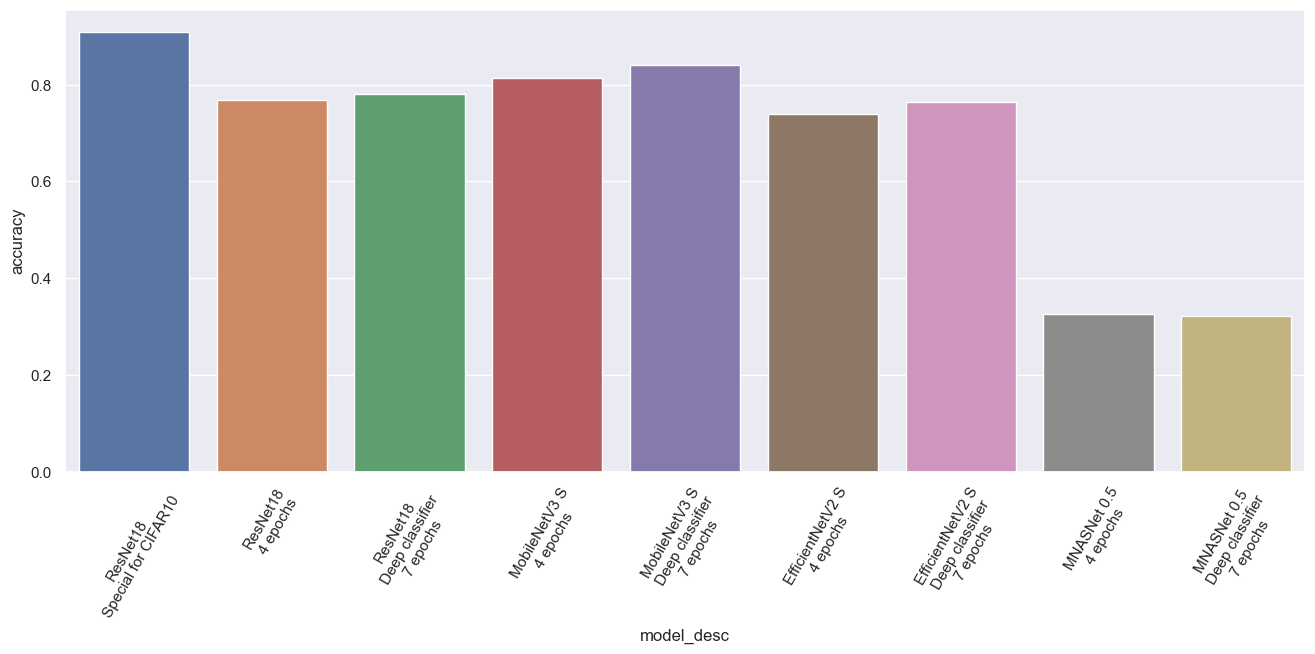

In [13]:
sns.set(rc={'figure.figsize': (16, 6)})

g = sns.barplot(data=data, x='model_desc', y='accuracy', hue="model_desc")
for item in g.get_xticklabels():
    item.set_rotation(60)